In [1]:
from music21 import *
import glob
import numpy as np
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.callbacks import History, ModelCheckpoint
from keras.optimizers import RMSprop
from datetime import datetime

/home/eurismar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/eurismar/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [97]:
#path = '/home/eurismar/notebooks/Music_Generator_Demo/Pop_Music_Midi/'
path = '/home/eurismar/Downloads/midi/Harpa.Crista.em.Arquivo.MIDI'
#path = '/home/eurismar/notebooks/c-rnn-gan/datadir/classical/chopin'

In [100]:
files = glob.glob('{}/*.MID*'.format(path))

In [101]:
files

['/home/eurismar/Downloads/midi/Harpa.Crista.em.Arquivo.MIDI/131.MID',
 '/home/eurismar/Downloads/midi/Harpa.Crista.em.Arquivo.MIDI/080.MID',
 '/home/eurismar/Downloads/midi/Harpa.Crista.em.Arquivo.MIDI/106.MID',
 '/home/eurismar/Downloads/midi/Harpa.Crista.em.Arquivo.MIDI/019.MID',
 '/home/eurismar/Downloads/midi/Harpa.Crista.em.Arquivo.MIDI/262.MID',
 '/home/eurismar/Downloads/midi/Harpa.Crista.em.Arquivo.MIDI/337.MID',
 '/home/eurismar/Downloads/midi/Harpa.Crista.em.Arquivo.MIDI/061.MID',
 '/home/eurismar/Downloads/midi/Harpa.Crista.em.Arquivo.MIDI/046.MID',
 '/home/eurismar/Downloads/midi/Harpa.Crista.em.Arquivo.MIDI/097.MID',
 '/home/eurismar/Downloads/midi/Harpa.Crista.em.Arquivo.MIDI/063.MID',
 '/home/eurismar/Downloads/midi/Harpa.Crista.em.Arquivo.MIDI/062.MID',
 '/home/eurismar/Downloads/midi/Harpa.Crista.em.Arquivo.MIDI/321.MID',
 '/home/eurismar/Downloads/midi/Harpa.Crista.em.Arquivo.MIDI/439.MID',
 '/home/eurismar/Downloads/midi/Harpa.Crista.em.Arquivo.MIDI/359.MID',
 '/hom

In [212]:
KEY_SIG_OFFSET = 0 
melody_corpus = []
for file in files[:3]:
#for file in files:
    midi_stream = converter.parse(file)
    
    part0 = midi_stream[0]
    key_sig = part0.keySignature
    print(key_sig)
    print('----->')
    midi_stream.transpose(KEY_SIG_OFFSET - key_sig.tonic.pitchClass, inPlace=True)
    print(key_sig)
    for m in part0.measures(1, None):
        for nr in m.flat.notesAndRests:
            pitch = nr.pitch.midi  if isinstance(nr, note.Note) else 0
            duration = float(nr.quarterLength)
            note_repr = (pitch+24, duration)
            melody_corpus.append(note_repr)

C major
----->
C major
C major
----->
C major
G major
----->
C major


In [213]:
melody_set = set(melody_corpus)

In [214]:
notes_indices = {note: i for i, note in enumerate(melody_set)}
indices_notes = {i: note for i, note in enumerate(melody_set)}

In [215]:
corpus_size = len(melody_set)
print(corpus_size)

70


In [216]:
phrase_len = 20
step_size = 3

In [217]:
phrases = []
next_notes = []

In [218]:
for i in range(0, len(melody_corpus) - phrase_len, step_size):
    phrases.append(melody_corpus[i: i + phrase_len])
    next_notes.append(melody_corpus[i + phrase_len])
print('nb sequences:', len(phrases))

nb sequences: 257


In [219]:
# transform data into binary matrices
X = np.zeros((len(phrases), phrase_len, corpus_size), dtype=np.bool)
y = np.zeros((len(phrases), corpus_size), dtype=np.bool)
print(X.shape)
print(y.shape)

(257, 20, 70)
(257, 70)


In [220]:
for i, phrase in enumerate(phrases):
    for j, note in enumerate(phrase):
        X[i, j, notes_indices[note]] = 1
    y[i, notes_indices[next_notes[i]]] = 1

In [221]:
layer_size=128
batch_size = 128
nb_epoch = 300

In [222]:
model = Sequential()
model.add(LSTM(layer_size, return_sequences=True, input_shape=(phrase_len, corpus_size)))
model.add(Dropout(0.2))
model.add(LSTM(layer_size, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(corpus_size))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [223]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 20, 128)           101888    
_________________________________________________________________
dropout_11 (Dropout)         (None, 20, 128)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 70)                9030      
_________________________________________________________________
activation_6 (Activation)    (None, 70)                0         
Total params: 242,502
Trainable params: 242,502
Non-trainable params: 0
_________________________________________________________________


In [224]:
history = History()

In [225]:
model.fit(X, y, batch_size=batch_size, epochs=nb_epoch, callbacks=[history])

Epoch 1/300
257/257 [==============================] - 1s - loss: 4.2367 - acc: 0.0545     
Epoch 2/300
257/257 [==============================] - 0s - loss: 4.1294 - acc: 0.1440     
Epoch 3/300
257/257 [==============================] - 0s - loss: 3.7556 - acc: 0.1323     
Epoch 4/300
257/257 [==============================] - 0s - loss: 3.5498 - acc: 0.1167     
Epoch 5/300
257/257 [==============================] - 0s - loss: 3.4110 - acc: 0.1167     
Epoch 6/300
257/257 [==============================] - 0s - loss: 3.3516 - acc: 0.1128     
Epoch 7/300
257/257 [==============================] - 0s - loss: 3.2633 - acc: 0.1401     
Epoch 8/300
257/257 [==============================] - 0s - loss: 3.2859 - acc: 0.1245     
Epoch 9/300
257/257 [==============================] - 0s - loss: 3.2195 - acc: 0.1245     
Epoch 10/300
257/257 [==============================] - 0s - loss: 3.4795 - acc: 0.0584     
Epoch 11/300
257/257 [==============================] - 0s - loss: 3.2522 - acc

257/257 [==============================] - 0s - loss: 2.6152 - acc: 0.2179     
Epoch 89/300
257/257 [==============================] - 0s - loss: 2.6341 - acc: 0.1829     
Epoch 90/300
257/257 [==============================] - 0s - loss: 2.9419 - acc: 0.1712     
Epoch 91/300
257/257 [==============================] - 0s - loss: 2.9844 - acc: 0.1556     
Epoch 92/300
257/257 [==============================] - 0s - loss: 2.7388 - acc: 0.1634     
Epoch 93/300
257/257 [==============================] - 0s - loss: 2.6245 - acc: 0.1712     
Epoch 94/300
257/257 [==============================] - 0s - loss: 2.6143 - acc: 0.2140     
Epoch 95/300
257/257 [==============================] - 0s - loss: 2.5823 - acc: 0.2101     
Epoch 96/300
257/257 [==============================] - 0s - loss: 2.5911 - acc: 0.2257     
Epoch 97/300
257/257 [==============================] - 0s - loss: 2.5558 - acc: 0.2335     
Epoch 98/300
257/257 [==============================] - 0s - loss: 2.5562 - acc: 0.

257/257 [==============================] - 0s - loss: 2.2777 - acc: 0.2529     
Epoch 176/300
257/257 [==============================] - 0s - loss: 2.1123 - acc: 0.2957     
Epoch 177/300
257/257 [==============================] - 0s - loss: 2.1066 - acc: 0.2918     
Epoch 178/300
257/257 [==============================] - 0s - loss: 2.1060 - acc: 0.3346     
Epoch 179/300
257/257 [==============================] - 0s - loss: 2.1181 - acc: 0.3074     
Epoch 180/300
257/257 [==============================] - 0s - loss: 2.0647 - acc: 0.3152     
Epoch 181/300
257/257 [==============================] - 0s - loss: 2.1976 - acc: 0.3035     
Epoch 182/300
257/257 [==============================] - 0s - loss: 2.1944 - acc: 0.2724     
Epoch 183/300
257/257 [==============================] - 0s - loss: 2.0727 - acc: 0.3113     
Epoch 184/300
257/257 [==============================] - 0s - loss: 2.1212 - acc: 0.2802     
Epoch 185/300
257/257 [==============================] - 0s - loss: 2.1249

257/257 [==============================] - 0s - loss: 1.8006 - acc: 0.4163     
Epoch 262/300
257/257 [==============================] - 0s - loss: 2.2092 - acc: 0.3074     
Epoch 263/300
257/257 [==============================] - 0s - loss: 1.9374 - acc: 0.3813     
Epoch 264/300
257/257 [==============================] - 0s - loss: 1.8932 - acc: 0.3696     
Epoch 265/300
257/257 [==============================] - 0s - loss: 1.8632 - acc: 0.3696     
Epoch 266/300
257/257 [==============================] - 0s - loss: 1.8045 - acc: 0.3813     
Epoch 267/300
257/257 [==============================] - 0s - loss: 1.7448 - acc: 0.4475     
Epoch 268/300
257/257 [==============================] - 0s - loss: 1.9287 - acc: 0.3307     
Epoch 269/300
257/257 [==============================] - 0s - loss: 1.8505 - acc: 0.3774     
Epoch 270/300
257/257 [==============================] - 0s - loss: 1.7374 - acc: 0.3735     
Epoch 271/300
257/257 [==============================] - 0s - loss: 1.8811

In [227]:
import matplotlib.pyplot as plt

dict_keys(['loss', 'acc'])


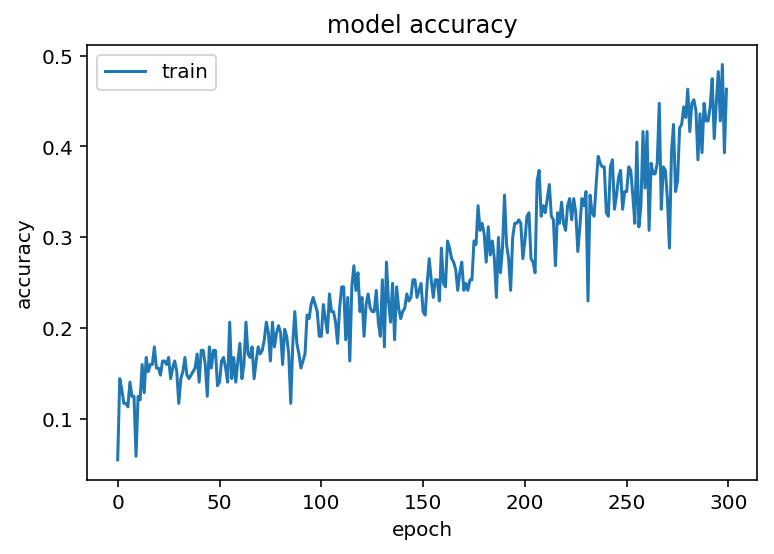

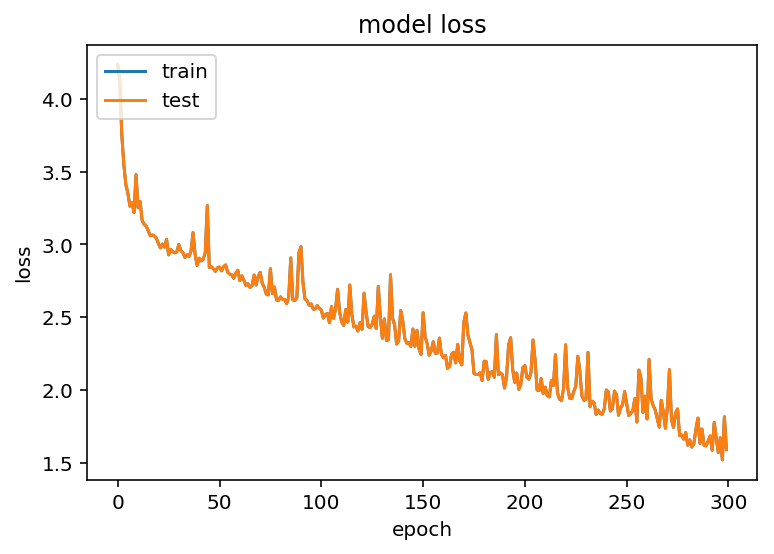

In [228]:

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [229]:
gen_melody_indices = np.zeros((1, phrase_len, len(melody_set)))
print(gen_melody_indices.shape)

(1, 20, 70)


In [230]:
start_pos = np.random.randint(0, len(melody_corpus) - phrase_len)

In [231]:
seed_phrase = melody_corpus[start_pos : start_pos + phrase_len]

In [232]:
gen_melody = seed_phrase

In [233]:
seq_len = 100

In [234]:
start = np.random.randint(0, len(phrases)-1)
pattern = phrases[start]
#print('pattern original:')
#print(pattern)
nova_sequencia = []
for i in range(seq_len):
    gen_melody_indices = np.zeros((1, phrase_len, len(melody_set)))
    for j, note in enumerate(pattern):
        gen_melody_indices[0, j, notes_indices[note]] = 1
    x = gen_melody_indices
    prediction = model.predict(x, verbose=0)[0]
    index = np.argmax(prediction)
    result = indices_notes[index]
    #print('result:',result)
    nova_sequencia.append(result)
    pattern.append(result)
    pattern = pattern[1:len(pattern)]
    #print('pattern {}:'.format(i))
    #print(pattern)

In [235]:
nova_sequencia

[(24, 2.0),
 (55, 1.0),
 (55, 1.0),
 (55, 1.0),
 (58, 1.0),
 (55, 1.0),
 (55, 1.0),
 (58, 1.0),
 (58, 1.0),
 (58, 1.0),
 (58, 1.0),
 (58, 1.0),
 (58, 1.0),
 (58, 1.0),
 (24, 0.25),
 (45, 1.0),
 (58, 1.0),
 (24, 0.25),
 (58, 1.0),
 (58, 1.0),
 (58, 1.0),
 (49, 0.6666666666666666),
 (49, 0.6666666666666666),
 (49, 0.6666666666666666),
 (49, 0.6666666666666666),
 (49, 0.6666666666666666),
 (49, 0.6666666666666666),
 (49, 0.6666666666666666),
 (49, 0.6666666666666666),
 (49, 0.6666666666666666),
 (49, 0.6666666666666666),
 (49, 0.6666666666666666),
 (49, 0.6666666666666666),
 (58, 1.0),
 (58, 1.0),
 (58, 1.0),
 (49, 0.6666666666666666),
 (49, 0.6666666666666666),
 (62, 0.5),
 (59, 0.6666666666666666),
 (55, 0.3333333333333333),
 (53, 0.6666666666666666),
 (53, 0.6666666666666666),
 (53, 0.6666666666666666),
 (57, 0.6666666666666666),
 (57, 0.6666666666666666),
 (57, 0.6666666666666666),
 (57, 0.6666666666666666),
 (57, 0.6666666666666666),
 (57, 0.6666666666666666),
 (57, 0.666666666666666

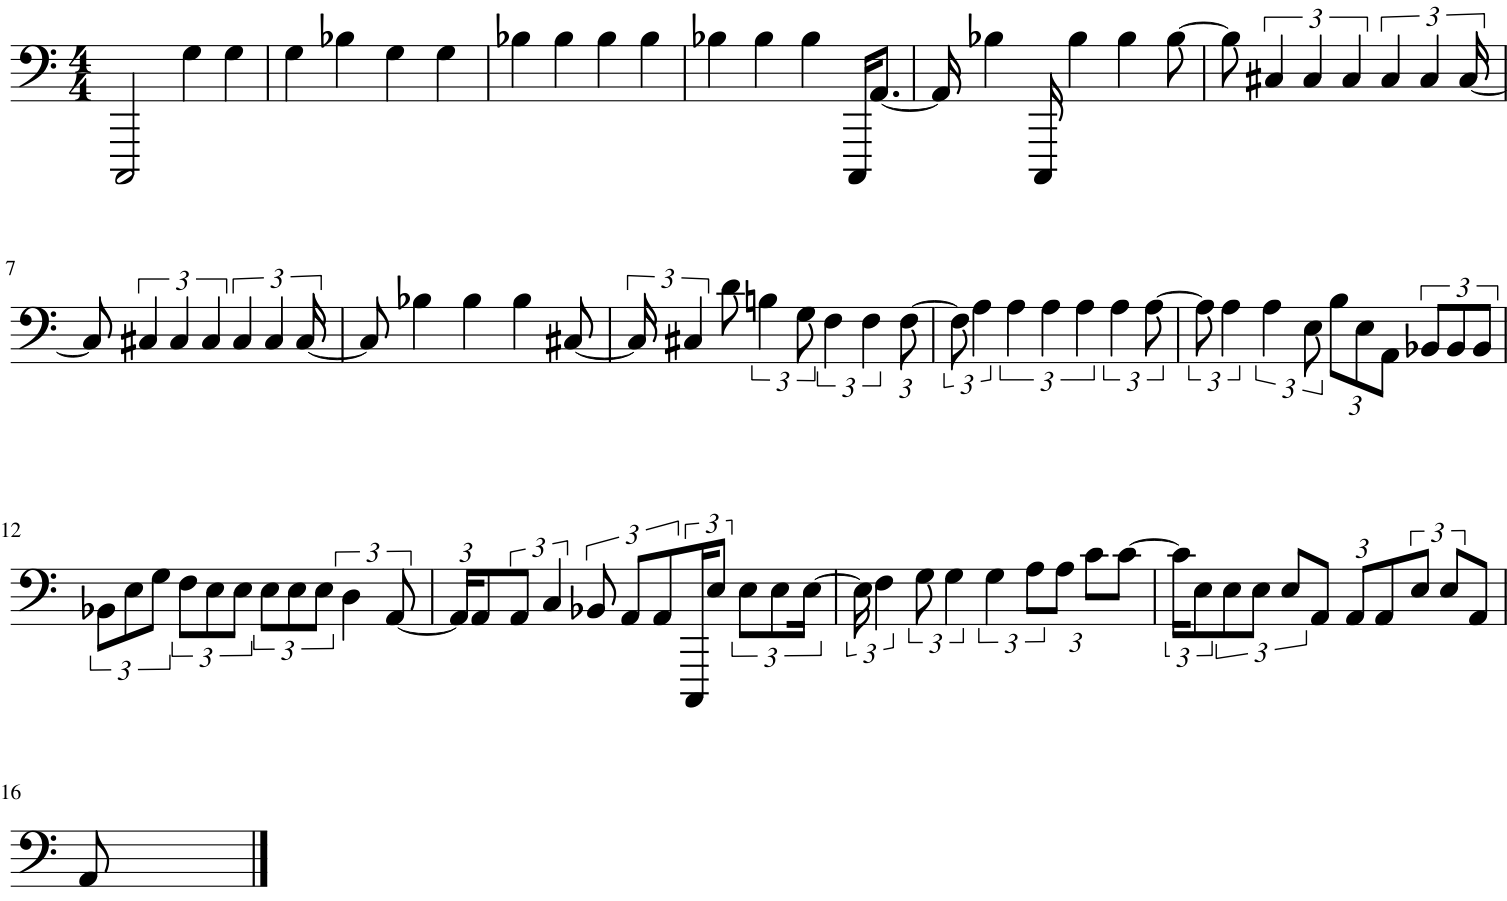

In [236]:
from music21 import *
sc = stream.Score()
for t in nova_sequencia:
    if t[1] == 0.0:
        r = note.Rest(quarterLength = 0.25)
        sc.append(r)
    else:
        n = note.Note(midi=t[0], quarterLength=t[1])
        sc.append(n)
sc.show()

In [237]:
filename = "gerada_" + datetime.now().strftime("%Y%m%d-%H%M%S"+".mid")

In [238]:
print(filename)

gerada_20180627-021008.mid


In [239]:
from music21 import *
mf = midi.translate.streamToMidiFile(sc)
mf.open(filename, 'wb')
mf.write()
mf.close()

In [240]:
!ls gerada_20180627-011258.mid

gerada_20180627-011258.mid


In [241]:
!pwd

/home/eurismar/notebooks/JohaNN
